In [1069]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import numpy as np
import time
import pandas as pd
from joblib import dump, load
import itertools

In [ ]:
# import language tools
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [349]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "my_palette.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


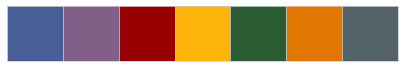

In [280]:
# import custom palette
import my_palette as mp

In [1378]:
# import dataset
df = pd.read_json('../../data/all_lang_genres_taglines_ds.json')
df

,genres,tagline
2,"[Crime, Comedy]",Twelve outrageous guests. Four scandalous requ...
3,"[Action, Thriller, Crime]",Don't move. Don't whisper. Don't even breathe.
4,[Documentary],A Megacities remix.
6,"[Adventure, Action, Science Fiction]","A long time ago in a galaxy far, far away..."
7,"[Animation, Family]",There are 3.7 trillion fish in the ocean. They...
...,...,...
545667,[Documentary],The One and Only June Foray
545704,"[History, Drama]",Vera Komissarzhevskaya
545742,[Comedy],Stop Running You Ass-Hole
545761,"[Comedy, Western, Horror, Music]",Senior Slump never looked so good.


In [1304]:
# observe unique combinations of genres
df['genres'].apply(tuple).value_counts()

(Documentary,)                                   6541
(Drama,)                                         6155
(Comedy,)                                        4568
(Horror,)                                        2906
(Music,)                                         1583
                                                 ... 
(Crime, Drama, Mystery, Thriller, Action)           1
(Adventure, Western, Romance)                       1
(Comedy, Crime, Drama, Horror, Thriller)            1
(Science Fiction, Fantasy, Adventure, Action)       1
(Horror, Animation, Family, Music, Comedy)          1
Name: genres, Length: 4806, dtype: int64

In [1379]:
# get number of genres in longest genre list
max_genres = df['genres'].apply(lambda x: len(x)).max()
max_genres

9

In [1306]:
def remove_padding(lst):
    """Return list without empty string padding"""
    new_lst = [char for char in lst if char != '']
    
    return new_lst

In [1307]:
def separate_genres(data):
    """Return dataset with genres as features"""
    # pad genres lists to be same length as longest list
    for row in data['genres']:
        while len(row) < max_genres:
            row.append('')   
            
    # pluck out genres, in order
    for genre in range(max_genres):
        data['genre_' + str(genre + 1)] = data['genres'].apply(lambda x: x[genre])
        
    # return genres column to original form
    data['genres'] = data['genres'].apply(remove_padding)
    
    return data

In [1380]:
# observe new dataset
df = separate_genres(df)
df

,genres,tagline,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9
2,"[Crime, Comedy]",Twelve outrageous guests. Four scandalous requ...,Crime,Comedy,,,,,,,
3,"[Action, Thriller, Crime]",Don't move. Don't whisper. Don't even breathe.,Action,Thriller,Crime,,,,,,
4,[Documentary],A Megacities remix.,Documentary,,,,,,,,
6,"[Adventure, Action, Science Fiction]","A long time ago in a galaxy far, far away...",Adventure,Action,Science Fiction,,,,,,
7,"[Animation, Family]",There are 3.7 trillion fish in the ocean. They...,Animation,Family,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
545667,[Documentary],The One and Only June Foray,Documentary,,,,,,,,
545704,"[History, Drama]",Vera Komissarzhevskaya,History,Drama,,,,,,,
545742,[Comedy],Stop Running You Ass-Hole,Comedy,,,,,,,,
545761,"[Comedy, Western, Horror, Music]",Senior Slump never looked so good.,Comedy,Western,Horror,Music,,,,,


In [1309]:
# get count of primary genres
df['genre_1'].value_counts()

Drama              13762
Comedy             10846
Documentary         7916
Action              6039
Horror              5853
Thriller            3130
Crime               2390
Music               2379
Romance             2006
Adventure           1902
Western             1684
Animation           1595
Science Fiction     1343
Family               968
Fantasy              865
Mystery              844
TV Movie             425
War                  419
History              344
Name: genre_1, dtype: int64

In [12]:
# load language library
nlp = spacy.load('en_core_web_lg')

In [14]:
# get string of punctuations
punctuations = string.punctuation
# get list of English stop words
stopwords = list(STOP_WORDS)

In [15]:
# instantiate NLP object and text-processing pipeline
parser = English()

In [1413]:
def get_tokens(tagline):
    """Returns tokenized taglines"""
    # process taglines
    doc = parser(tagline)
    doc = [token.lemma_.lower().strip() \
              if token.lemma_ != '-PRON-' \
              else token.lower_ for token in doc]
    # remove stop words and punctuation
    doc = [token for token in doc \
              if token not in stopwords and token not in punctuations]
    # combine processed tokens
    doc = " ".join([i for i in doc])
    
    return doc

In [1414]:
# tokenize taglines
tagline_tokens = df['tagline'].apply(get_tokens)

In [1415]:
# observe tokenization
tagline_tokens

2         outrageous guests scandalous requests lone bel...
3                                           whisper breathe
4                                          megacities remix
6                     long time ago galaxy far far away ...
7                           3.7 trillion fish ocean looking
                                ...                        
545667                                           june foray
545704                               vera komissarzhevskaya
545742                                stop running ass hole
545761                             senior slump looked good
545797                                       bipolar living
Name: tagline, Length: 64710, dtype: object

In [1416]:
# instantiate CountVectorizer object
cv = CountVectorizer(max_df=0.95, min_df=5)
# transform tokens into Document-term Matrix
dtm = cv.fit_transform(tagline_tokens)

In [20]:
# observe Document-term Matrix
dtm

<64710x6777 sparse matrix of type '<class 'numpy.int64'>'
	with 233704 stored elements in Compressed Sparse Row format>

In [1359]:
# get count of unique primary genres to set as number of desired topics
num_genres = len(df['genre_1'].value_counts())
num_genres

19

In [21]:
# instantiate Latent Dirichlet Allocation(LDA) object
lda = LatentDirichletAllocation(n_components=num_genres, random_state=27)

In [22]:
%%time
# model topics with LDA
lda.fit(dtm)

CPU times: user 1min 10s, sys: 16.9 ms, total: 1min 10s
Wall time: 1min 10s


LatentDirichletAllocation(n_components=19, random_state=27)

In [853]:
# save sklearn lda model
dump(lda, '../../saved_models/skl_lda.joblib')

['../../saved_models/skl_lda.joblib']

In [851]:
# get topic probabilities for topics
genre_results = lda.transform(dtm)
genre_results

In [1384]:
# add LDA topics to original dataset
df['lda_topic'] = genre_results.argmax(axis=1)
# reorder columns
col_lst = df.columns.tolist()
moved_col =  col_lst.pop()
col_lst.insert((len(df.columns) - max_genres - 1), moved_col)
df = df[col_lst]
df

,genres,tagline,lda_topic,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9
2,"[Crime, Comedy]",Twelve outrageous guests. Four scandalous requ...,4,Crime,Comedy,,,,,,,
3,"[Action, Thriller, Crime]",Don't move. Don't whisper. Don't even breathe.,18,Action,Thriller,Crime,,,,,,
4,[Documentary],A Megacities remix.,0,Documentary,,,,,,,,
6,"[Adventure, Action, Science Fiction]","A long time ago in a galaxy far, far away...",18,Adventure,Action,Science Fiction,,,,,,
7,"[Animation, Family]",There are 3.7 trillion fish in the ocean. They...,3,Animation,Family,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
545667,[Documentary],The One and Only June Foray,16,Documentary,,,,,,,,
545704,"[History, Drama]",Vera Komissarzhevskaya,5,History,Drama,,,,,,,
545742,[Comedy],Stop Running You Ass-Hole,3,Comedy,,,,,,,,
545761,"[Comedy, Western, Horror, Music]",Senior Slump never looked so good.,16,Comedy,Western,Horror,Music,,,,,


In [1312]:
def get_genre_dist(data):
    """Return distribution of genre labels sorted by LDA genre topics"""
    # make list of columns to leave out
    dropped_cols_lst = data.columns[:-max_genres].to_list()
    
    # create DataFrame with true distribution of genre labels
    dist_df = pd.DataFrame(
        data.drop(
            dropped_cols_lst, axis=1).apply(
            pd.Series.value_counts, normalize=True).sum(
            axis=1).sort_values(
            ascending=False)[1:])

    # iterate through topics
    for topic in range(num_genres):
        # add topic distribution to data
        dist_df = pd.concat(
            [dist_df, 
             data[data[data.columns[-max_genres - 1]] == topic].drop(
                 dropped_cols_lst, axis=1).apply(
                 pd.Series.value_counts, normalize=True).sum(
                 axis=1).sort_values(
                 ascending=False)[1:]
            ], 
            axis=1, ignore_index=True)
        
    # create empty list for column names
    topic_names = []
    
    # iterate through topics
    for topic in range(num_genres):
        # add topic name to list
        topic_names.append('topic_' + str(topic))
        
    # add column name of true distribution
    topic_names.insert(0, 'true_dist')
    # name DataFrame columns
    dist_df.columns = topic_names
        
    return dist_df

In [1385]:
# create DataFrame of unmodified genre distribution by topic 
raw_dist_df = get_genre_dist(df)
raw_dist_df

,true_dist,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
Drama,0.362262,0.354610,0.360251,0.363793,0.342857,0.323636,0.285114,0.350571,0.305783,0.470949,0.390695,0.309591,0.420260,0.373385,0.439748,0.311804,0.420193,0.340077,0.356567,0.342784
Comedy,0.250518,0.277938,0.251653,0.193068,0.222917,0.346061,0.192677,0.276609,0.323948,0.265401,0.192365,0.235239,0.265991,0.253553,0.202153,0.214763,0.246863,0.249033,0.292675,0.253265
Thriller,0.161242,0.129576,0.184476,0.224864,0.233333,0.133939,0.135954,0.188214,0.162882,0.129051,0.205189,0.160262,0.152243,0.184432,0.117091,0.142857,0.152903,0.172270,0.161020,0.115642
Horror,0.144707,0.117500,0.163940,0.157834,0.227381,0.137879,0.120048,0.207156,0.209507,0.098686,0.138682,0.142143,0.123300,0.166021,0.083749,0.147630,0.115845,0.144600,0.160697,0.116916
Action,0.139901,0.113283,0.136791,0.169865,0.165774,0.106364,0.191477,0.129886,0.129276,0.102774,0.211452,0.133708,0.124168,0.146318,0.125492,0.160993,0.133936,0.122583,0.136496,0.134438
Documentary,0.137506,0.155070,0.164984,0.137783,0.099702,0.128485,0.099640,0.104630,0.116863,0.115620,0.109454,0.226179,0.141245,0.114018,0.197165,0.188991,0.109717,0.114252,0.121329,0.159286
Romance,0.120584,0.093732,0.116255,0.101404,0.095833,0.179697,0.099940,0.114251,0.095368,0.236496,0.096630,0.090597,0.138929,0.133075,0.136256,0.104677,0.143566,0.094317,0.117780,0.109908
Crime,0.090110,0.083765,0.109293,0.099971,0.102679,0.072727,0.102941,0.096813,0.073569,0.091095,0.104086,0.086223,0.077279,0.107558,0.087162,0.067770,0.114969,0.096697,0.082930,0.057343
Adventure,0.069587,0.049645,0.060216,0.069321,0.070238,0.066061,0.103842,0.059531,0.065698,0.057518,0.090367,0.068104,0.061071,0.065568,0.080336,0.082724,0.065071,0.050580,0.064860,0.102580
Science Fiction,0.066605,0.051371,0.062652,0.117158,0.085417,0.058182,0.053721,0.061936,0.079322,0.045839,0.074858,0.065292,0.053546,0.045866,0.056445,0.131085,0.048147,0.043439,0.060665,0.081873


In [1386]:
# create DataFrame of genre distribution by topic proportional to true distibution
prop_dist_df = raw_dist_df.apply(lambda x: x / raw_dist_df['true_dist'])
prop_dist_df

,true_dist,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
Drama,1.0,0.978876,0.994447,1.004224,0.946433,0.893376,0.787037,0.967727,0.844092,1.300021,1.078486,0.854604,1.160100,1.030703,1.213893,0.860713,1.159912,0.938760,0.984277,0.946232
Comedy,1.0,1.109453,1.004533,0.770676,0.889824,1.381382,0.769116,1.104148,1.293114,1.059412,0.767870,0.939011,1.061767,1.012116,0.806940,0.857277,0.985412,0.994074,1.168281,1.010968
Thriller,1.0,0.803612,1.144092,1.394570,1.447096,0.830671,0.843167,1.167274,1.010170,0.800354,1.272552,0.993922,0.944188,1.143815,0.726180,0.885977,0.948283,1.068392,0.998618,0.717193
Horror,1.0,0.811988,1.132910,1.090716,1.571318,0.952813,0.829593,1.431551,1.447796,0.681971,0.958362,0.982281,0.852063,1.147287,0.578748,1.020196,0.800546,0.999258,1.110498,0.807950
Action,1.0,0.809740,0.977768,1.214182,1.184936,0.760277,1.368657,0.928411,0.924056,0.734617,1.511442,0.955734,0.887540,1.045866,0.897007,1.150761,0.957365,0.876209,0.975658,0.960948
Documentary,1.0,1.127734,1.199836,1.002015,0.725078,0.934396,0.724623,0.760915,0.849880,0.840840,0.795997,1.644871,1.027190,0.829188,1.433864,1.374425,0.797908,0.830887,0.882359,1.158398
Romance,1.0,0.777316,0.964097,0.840937,0.794742,1.490221,0.828799,0.947482,0.790882,1.961256,0.801348,0.751315,1.152134,1.103586,1.129968,0.868083,1.190586,0.782169,0.976745,0.911460
Crime,1.0,0.929585,1.212893,1.109440,1.139484,0.807097,1.142398,1.074390,0.816443,1.010933,1.155102,0.956867,0.857613,1.193635,0.967287,0.752079,1.275882,1.073107,0.920322,0.636370
Adventure,1.0,0.713425,0.865326,0.996173,1.009351,0.949319,1.492246,0.855485,0.944106,0.826561,1.298609,0.978679,0.877615,0.942247,1.154463,1.188772,0.935105,0.726858,0.932060,1.474124
Science Fiction,1.0,0.771273,0.940656,1.759007,1.282439,0.873537,0.806570,0.929906,1.190932,0.688229,1.123917,0.980290,0.803929,0.688623,0.847465,1.968099,0.722876,0.652197,0.910815,1.229238


In [1387]:
# pair each genre label with topic that holds largest proportion of that genre
rough_map = prop_dist_df.idxmax(axis=1).sort_values()
rough_map

Animation           topic_0
TV Movie            topic_1
Documentary        topic_10
History            topic_13
Science Fiction    topic_14
Crime              topic_15
Music              topic_16
Family             topic_18
Fantasy            topic_18
Mystery             topic_2
Horror              topic_3
Thriller            topic_3
Comedy              topic_4
Adventure           topic_5
Western             topic_5
Romance             topic_8
Drama               topic_8
War                 topic_9
Action              topic_9
dtype: object

In [987]:
def map_topics(data):
    """Return mapping of topic to closest genre as dictionary"""
    # create empty mapping dicts
    topic_map = {}
    remaining_map = {}
    
    # get array of all topics from map
    all_map_topics = np.unique(data.values)
    # get array of uniquely matched topics
    matched_topics = data[data.duplicated(keep=False) == False].keys()
    
    # iterate through topics
    for genre in data.keys():
        # convert string topic name to LDA integer value
        int_topic = int(data[genre].split('_')[1])
        if genre in matched_topics:
            # add to mapped dict
            topic_map[genre] = int_topic
        else:
            # add to unmapped dict
            remaining_map[genre] = int_topic
    
    return remaining_map, topic_map

In [1390]:
# break off unique matches
remaining_map, topic_map = map_topics(rough_map)

In [1391]:
# observe matched genres
topic_map

{'Animation': 0,
 'TV Movie': 1,
 'Documentary': 10,
 'History': 13,
 'Science Fiction': 14,
 'Crime': 15,
 'Music': 16,
 'Mystery': 2,
 'Comedy': 4}

In [1392]:
# observe unmatched genres
remaining_map

{'Family': 18,
 'Fantasy': 18,
 'Horror': 3,
 'Thriller': 3,
 'Adventure': 5,
 'Western': 5,
 'Romance': 8,
 'Drama': 8,
 'War': 9,
 'Action': 9}

In [1137]:
def pair_duplicates(duplicates_map):
    """Returns dictionary of topic and multiple associated genres"""
    # create empty list and dict to hold doubled genre pairs
    duplicates_lst = []
    duplicates_dict = {}
    
    # iterate through topics
    for topic in duplicates_map.values(): 
        doubled_genres = [k for k, v in duplicates_map.items() if v == topic]
        duplicates_lst.append(doubled_genres)
        
    # remove duplicate lists and replace with tuples
    duplicates_lst = list(k for k, _ in itertools.groupby(duplicates_lst))
    # get topics, while preserving order
    topics = list(dict.fromkeys(duplicates_map.values()))
    # populate duplicates dictionary
    duplicates_dict = dict(zip(topics, duplicates_lst))
        
    return duplicates_dict

In [1393]:
# get dictionary of topics with their duplicate genre
duplicates_dict = pair_duplicates(remaining_map)
duplicates_dict

{18: ['Family', 'Fantasy'],
 3: ['Horror', 'Thriller'],
 5: ['Adventure', 'Western'],
 8: ['Romance', 'Drama'],
 9: ['War', 'Action']}

In [1160]:
def break_ties(remaining_dict, dist_df):
    """Return informed mapping of remaining genres"""
    # create dictionary to hold matched genres
    matched_genres = {}
    # create list to hold unmatched genres
    unmatched_lst = []
    
    # iterate through topics
    for topic, duplicate_genres in remaining_dict.items():
        # get genre indices with largest proportional representation by topic
        matched_genre_idx = np.argmax(
            list(
                map(
                    lambda x: dist_df.loc[x, 'topic_' + str(topic)], 
                    duplicate_genres)))
        # get label for best choice of genre for topic
        matched_genre = duplicate_genres[matched_genre_idx]
        # add matched genre to dictionary
        matched_genres[topic] = matched_genre
        
        # collect unmatched genres
        duplicate_genres.pop(matched_genre_idx)
        unmatched_lst.append(duplicate_genres)
        # flatten unmatched genres list
        flat_lst = list(np.array(unmatched_lst).flat)
        
        # invert key value mappings to match topic_map dictionary
        inv_matched_genres = {v: k for k, v in matched_genres.items()}
        
    return inv_matched_genres, flat_lst

In [1394]:
# select best genre match for topics with multiple genres
matched_genres, remaining_genres = break_ties(duplicates_dict, prop_dist_df)

In [1395]:
# append newly selected matches to original matched dictionary
topic_map.update(matched_genres)
topic_map

{'Animation': 0,
 'TV Movie': 1,
 'Documentary': 10,
 'History': 13,
 'Science Fiction': 14,
 'Crime': 15,
 'Music': 16,
 'Mystery': 2,
 'Comedy': 4,
 'Family': 18,
 'Horror': 3,
 'Western': 5,
 'Romance': 8,
 'War': 9}

In [1396]:
# observe remaining genres to match with a topic
remaining_genres

['Fantasy', 'Thriller', 'Adventure', 'Drama', 'Action']

In [1397]:
# get unmatched topics
remaining_topics = []
for topic in range(num_genres):
    if topic not in topic_map.values():
        remaining_topics.append(topic)
remaining_topics        

[6, 7, 11, 12, 17]

In [1398]:
# get new distribution DataFrame with unmatched genres and topics
remaining_dist_df = prop_dist_df.loc[remaining_genres, 
                                     list(
                                         map(
                                             lambda x: 'topic_' + str(x), 
                                             remaining_topics))]
remaining_dist_df

,topic_6,topic_7,topic_11,topic_12,topic_17
Fantasy,1.236276,1.105791,0.970710,0.801323,1.163758
Thriller,1.167274,1.010170,0.944188,1.143815,0.998618
Adventure,0.855485,0.944106,0.877615,0.942247,0.932060
Drama,0.967727,0.844092,1.160100,1.030703,0.984277
Action,0.928411,0.924056,0.887540,1.045866,0.975658


In [1399]:
# pair each genre label with topic that holds largest proportion of that genre
final_rough_map = remaining_dist_df.idxmax(axis=1).sort_values()
final_rough_map

Drama        topic_11
Action       topic_12
Fantasy       topic_6
Thriller      topic_6
Adventure     topic_7
dtype: object

In [1400]:
# break off unique matches
final_remaining_map, additional_topic_map = map_topics(final_rough_map)

In [1401]:
# observe last unmatched genres
final_remaining_map

{'Fantasy': 6, 'Thriller': 6}

In [1402]:
# observe new matched genres
additional_topic_map

{'Drama': 11, 'Action': 12, 'Adventure': 7}

In [1403]:
# append newly selected matches to original matched dictionary
topic_map.update(additional_topic_map)
topic_map

{'Animation': 0,
 'TV Movie': 1,
 'Documentary': 10,
 'History': 13,
 'Science Fiction': 14,
 'Crime': 15,
 'Music': 16,
 'Mystery': 2,
 'Comedy': 4,
 'Family': 18,
 'Horror': 3,
 'Western': 5,
 'Romance': 8,
 'War': 9,
 'Drama': 11,
 'Action': 12,
 'Adventure': 7}

In [1404]:
# get dictionary of topics with their duplicate genre
final_duplicates_dict = pair_duplicates(final_remaining_map)
final_duplicates_dict

{6: ['Fantasy', 'Thriller']}

In [1405]:
# select best genre match for topics with multiple genres
matched_genres, remaining_genres = break_ties(final_duplicates_dict, remaining_dist_df)

In [1406]:
# append newly selected matches to original matched dictionary
topic_map.update(matched_genres)
topic_map

{'Animation': 0,
 'TV Movie': 1,
 'Documentary': 10,
 'History': 13,
 'Science Fiction': 14,
 'Crime': 15,
 'Music': 16,
 'Mystery': 2,
 'Comedy': 4,
 'Family': 18,
 'Horror': 3,
 'Western': 5,
 'Romance': 8,
 'War': 9,
 'Drama': 11,
 'Action': 12,
 'Adventure': 7,
 'Fantasy': 6}

In [1407]:
# observe remaining genre to match with a topic
remaining_genres

['Thriller']

In [1408]:
# get final unmatched topic
remaining_topics = []
for topic in range(num_genres):
    if topic not in topic_map.values():
        remaining_topics.append(topic)
remaining_topics 

[17]

In [1409]:
# append final matches to original matched dictionary
topic_map.update({remaining_genres[0]: remaining_topics[0]})
topic_map

{'Animation': 0,
 'TV Movie': 1,
 'Documentary': 10,
 'History': 13,
 'Science Fiction': 14,
 'Crime': 15,
 'Music': 16,
 'Mystery': 2,
 'Comedy': 4,
 'Family': 18,
 'Horror': 3,
 'Western': 5,
 'Romance': 8,
 'War': 9,
 'Drama': 11,
 'Action': 12,
 'Adventure': 7,
 'Fantasy': 6,
 'Thriller': 17}

In [1410]:
lda_topics = genre_results.argmax(axis=1)
lda_topics

array([ 4, 18,  0, ...,  3, 16,  7])

In [1411]:
# inverse mapping dictionary
inv_topic_map = {v: k for k, v in topic_map.items()}
# map LDA topics to genre labels for each movie
lda_genres = np.array([inv_topic_map.get(i, i) for i in lda_topics])
lda_genres

array(['Comedy', 'Family', 'Animation', ..., 'Horror', 'Music',
       'Adventure'], dtype='<U15')

In [1412]:
# remove single genre columns
df = df.iloc[:, :len(df.columns) - max_genres]
# add LDA genres to original dataset
df['lda_genre'] = lda_genres
df

,genres,tagline,lda_topic,lda_genre
2,"[Crime, Comedy]",Twelve outrageous guests. Four scandalous requ...,4,Comedy
3,"[Action, Thriller, Crime]",Don't move. Don't whisper. Don't even breathe.,18,Family
4,[Documentary],A Megacities remix.,0,Animation
6,"[Adventure, Action, Science Fiction]","A long time ago in a galaxy far, far away...",18,Family
7,"[Animation, Family]",There are 3.7 trillion fish in the ocean. They...,3,Horror
...,...,...,...,...
545667,[Documentary],The One and Only June Foray,16,Music
545704,"[History, Drama]",Vera Komissarzhevskaya,5,Western
545742,[Comedy],Stop Running You Ass-Hole,3,Horror
545761,"[Comedy, Western, Horror, Music]",Senior Slump never looked so good.,16,Music


In [1424]:
# observe top words in topic and most probable genre label
for topic, word_probs in enumerate(lda.components_):
    print(f'Top 15 Word for Topic {topic} ({inv_topic_map[topic]}):')
    print([cv.get_feature_names()[i] for i in word_probs.argsort()[-15:]])
    print('\n')

Top 15 Word for Topic 0 (Animation):
['business', 'trouble', 'vengeance', 'american', 'trust', 'friend', 'animation', 'small', 'crime', 'dream', 'town', 'short', 'comes', 'big', 'film']


Top 15 Word for Topic 1 (TV Movie):
['begin', 'worst', '000', 'rise', 'getting', 'summer', 'easy', 'freedom', 'lies', 'law', 'nightmare', 'hard', 'going', 'let', 'great']


Top 15 Word for Topic 2 (Mystery):
['eyes', 'forget', 'loves', 'world', 'ready', 'justice', 'murder', 'change', 'mind', 'save', 'power', 'future', 'past', 'kill', 'truth']


Top 15 Word for Topic 3 (Horror):
['choose', 'enemy', 'found', 'looking', 'lose', 'beginning', 'welcome', 'face', 'secrets', 'deadly', 'end', 'game', 'hell', 'evil', 'family']


Top 15 Word for Topic 4 (Comedy):
['action', 'obsession', 'mad', 'romantic', 'tell', 'changed', 'musical', 'art', 'romance', 'forever', 'screen', 'history', 'lives', 'terror', 'comedy']


Top 15 Word for Topic 5 (Western):
['guns', 'red', 'thrill', 'action', 'drama', 'born', 'ride', 'da